<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session8/Session_8_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks is all about having a potent classifier for Cifar-10 dataset with the following considerations:
* Make this network: C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11 cN is 1x1 Layer
* Keep the parameter count less than 50000
* Max Epochs is 20
* Use Batch Normalization

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 644.7 kB/s eta 0:00:00


## Helpers and Utils

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import seaborn as sns
import torch.nn.functional as F

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [6]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 128
epochs = 20
lr = 1e-3

Random seed set as 42
cuda


In [33]:
class EarlyStopping:

    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = "checkpoint.pt"
        self.trace_func = trace_func
    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Dataloader and pre-processing

In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])


In [9]:
# downloading train and test data
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 94018716.32it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

In [12]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [13]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [14]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

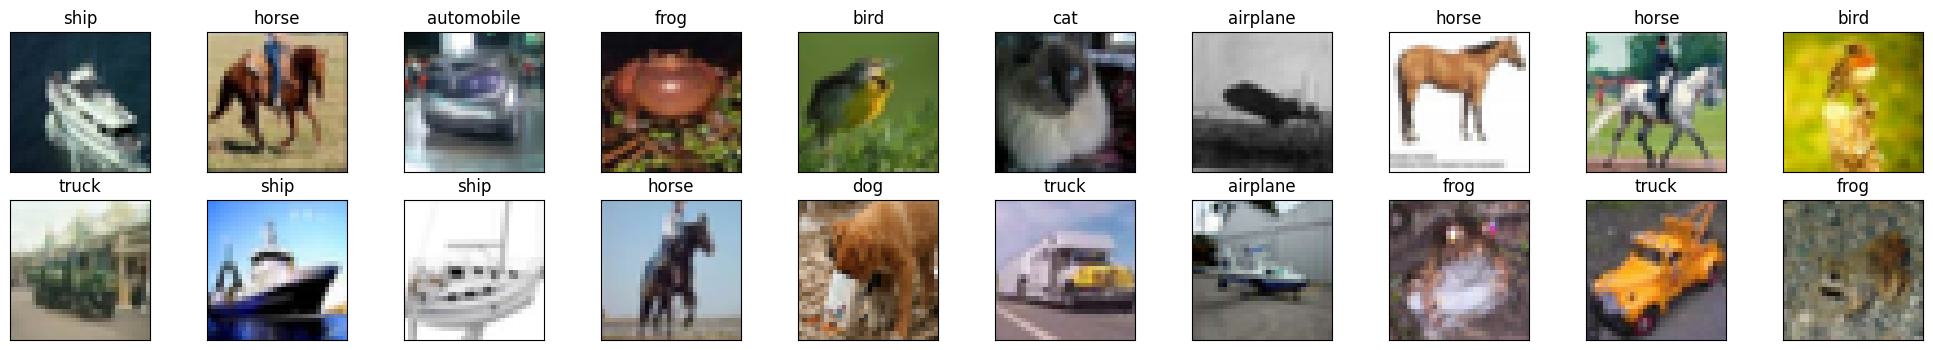

In [15]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Model Building and optimization

### Without dropouts and only BN

In [24]:
class Cifar_Baseline(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels, multiplier=1):
    super(Cifar_Baseline, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), # 30,3
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units,  kernel_size=3, stride=1, padding=0), #28,5
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #28,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #14,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #12,10
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #10,14
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #8,18
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
    )

    self.transition2= nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #8,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #4,20
    )

    self.conv3 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #2,28
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,36
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,44
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    self.gap = self.gap = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=1, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.transition2(x)
      x = self.conv3(x)
      x = self.gap(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [29]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [30]:
# updated testing modules---
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [31]:
# New Model Instance
baseline_model_1 = Cifar_Baseline(in_channels=3, hidden_units=16, out_channels=10 , multiplier=2).to(device)
summary(baseline_model_1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 32, 28, 28]           9,248
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]             528
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 32, 12, 12]           4,640
      BatchNorm2d-12           [-1, 32, 12, 12]              64
             ReLU-13           [-1, 32, 12, 12]               0
           Conv2d-14           [-1, 32,

In [34]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_1.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

In [35]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_1, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], baseline_model_1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 1.5930035236241566 Avg Train Metric: 0.3293162407472615: 100%|██████████| 391/391 [00:21<00:00, 18.26it/s]


Function Took 21.4188 seconds


Avg Test Loss: 1.3409057719798028 Avg Test Metric: 0.5216508039945289: 100%|██████████| 79/79 [00:03<00:00, 24.90it/s]


Function Took 3.1823 seconds
Validation loss decreased (inf --> 1.340906).  Saving model ...
Epoch 1


Avg Train Loss: 1.1051444432619588 Avg Train Metric: 0.5886816255881658: 100%|██████████| 391/391 [00:22<00:00, 17.69it/s]


Function Took 22.1109 seconds


Avg Test Loss: 1.0926323140723795 Avg Test Metric: 0.6120136138759081: 100%|██████████| 79/79 [00:03<00:00, 24.45it/s]


Function Took 3.2396 seconds
Validation loss decreased (1.340906 --> 1.092632).  Saving model ...
Epoch 2


Avg Train Loss: 0.9446294629360403 Avg Train Metric: 0.6602191675044692: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s]


Function Took 21.7665 seconds


Avg Test Loss: 1.0561845166773736 Avg Test Metric: 0.6390242802945874: 100%|██████████| 79/79 [00:03<00:00, 24.24it/s]


Function Took 3.2675 seconds
Validation loss decreased (1.092632 --> 1.056185).  Saving model ...
Epoch 3


Avg Train Loss: 0.8473057865791613 Avg Train Metric: 0.6972782849655736: 100%|██████████| 391/391 [00:23<00:00, 16.83it/s]


Function Took 23.2467 seconds


Avg Test Loss: 0.9559774836407432 Avg Test Metric: 0.6649416096602814: 100%|██████████| 79/79 [00:03<00:00, 23.79it/s]


Function Took 3.3307 seconds
Validation loss decreased (1.056185 --> 0.955977).  Saving model ...
Epoch 4


Avg Train Loss: 0.7847842132039082 Avg Train Metric: 0.7224520496700121: 100%|██████████| 391/391 [00:20<00:00, 19.02it/s]


Function Took 20.5754 seconds


Avg Test Loss: 0.8848521550999412 Avg Test Metric: 0.6945037238205536: 100%|██████████| 79/79 [00:04<00:00, 18.58it/s]


Function Took 4.2633 seconds
Validation loss decreased (0.955977 --> 0.884852).  Saving model ...
Epoch 5


Avg Train Loss: 0.7329566257689005 Avg Train Metric: 0.7443565628717622: 100%|██████████| 391/391 [00:20<00:00, 19.03it/s]


Function Took 20.5522 seconds


Avg Test Loss: 0.9041472311261334 Avg Test Metric: 0.6900450896613205: 100%|██████████| 79/79 [00:04<00:00, 18.47it/s]


Function Took 4.2857 seconds
EarlyStopping counter: 1 out of 5
Epoch 6


Avg Train Loss: 0.6936395217847946 Avg Train Metric: 0.7604365066799057: 100%|██████████| 391/391 [00:21<00:00, 18.60it/s]


Function Took 21.0320 seconds


Avg Test Loss: 0.8578471888469744 Avg Test Metric: 0.7096454916121084: 100%|██████████| 79/79 [00:03<00:00, 23.08it/s]


Function Took 3.4362 seconds
Validation loss decreased (0.884852 --> 0.857847).  Saving model ...
Epoch 7


Avg Train Loss: 0.6622205249336369 Avg Train Metric: 0.7718008093516845: 100%|██████████| 391/391 [00:21<00:00, 18.18it/s]


Function Took 21.5171 seconds


Avg Test Loss: 0.7846000866044925 Avg Test Metric: 0.7253386363198485: 100%|██████████| 79/79 [00:03<00:00, 24.24it/s]


Function Took 3.2689 seconds
Validation loss decreased (0.857847 --> 0.784600).  Saving model ...
Epoch 8


Avg Train Loss: 0.6329381151882278 Avg Train Metric: 0.7838817318077282: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]


Function Took 21.8663 seconds


Avg Test Loss: 0.7867267395876631 Avg Test Metric: 0.7298864329917522: 100%|██████████| 79/79 [00:03<00:00, 23.92it/s]


Function Took 3.3111 seconds
EarlyStopping counter: 1 out of 5
Epoch 9


Avg Train Loss: 0.6107919723024149 Avg Train Metric: 0.7934101073028487: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s]


Function Took 21.8774 seconds


Avg Test Loss: 0.7600437349910978 Avg Test Metric: 0.7457493573804445: 100%|██████████| 79/79 [00:03<00:00, 24.03it/s]


Function Took 3.2933 seconds
Validation loss decreased (0.784600 --> 0.760044).  Saving model ...
Epoch 10


Avg Train Loss: 0.5842768896723647 Avg Train Metric: 0.8037263557429204: 100%|██████████| 391/391 [00:21<00:00, 17.87it/s]


Function Took 21.8900 seconds


Avg Test Loss: 0.8169857520091383 Avg Test Metric: 0.7252928290186049: 100%|██████████| 79/79 [00:03<00:00, 23.65it/s]


Function Took 3.3478 seconds
EarlyStopping counter: 1 out of 5
Epoch 11


Avg Train Loss: 0.5614812331431357 Avg Train Metric: 0.8106399445277651: 100%|██████████| 391/391 [00:21<00:00, 18.47it/s]


Function Took 21.1757 seconds


Avg Test Loss: 0.7900958129122287 Avg Test Metric: 0.7357507008540479: 100%|██████████| 79/79 [00:03<00:00, 19.86it/s]


Function Took 3.9858 seconds
EarlyStopping counter: 2 out of 5
Epoch 12


Avg Train Loss: 0.5452840742095352 Avg Train Metric: 0.8185083352391372: 100%|██████████| 391/391 [00:20<00:00, 18.85it/s]


Function Took 20.7466 seconds


Avg Test Loss: 0.7877078003521207 Avg Test Metric: 0.7399936393846439: 100%|██████████| 79/79 [00:04<00:00, 18.08it/s]


Function Took 4.3799 seconds
EarlyStopping counter: 3 out of 5
Epoch 13


Avg Train Loss: 0.5264723866491976 Avg Train Metric: 0.8206507789204492: 100%|██████████| 391/391 [00:20<00:00, 18.83it/s]


Function Took 20.7741 seconds


Avg Test Loss: 0.8223086240925367 Avg Test Metric: 0.7393446217609357: 100%|██████████| 79/79 [00:03<00:00, 24.29it/s]


Function Took 3.2629 seconds
EarlyStopping counter: 4 out of 5
Epoch 14


Avg Train Loss: 0.5089414089232149 Avg Train Metric: 0.8285727834762515: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s]


Function Took 21.8161 seconds


Avg Test Loss: 0.8005247991296309 Avg Test Metric: 0.7339065414440783: 100%|██████████| 79/79 [00:03<00:00, 24.24it/s]

Function Took 3.2670 seconds
EarlyStopping counter: 5 out of 5
Early stopping


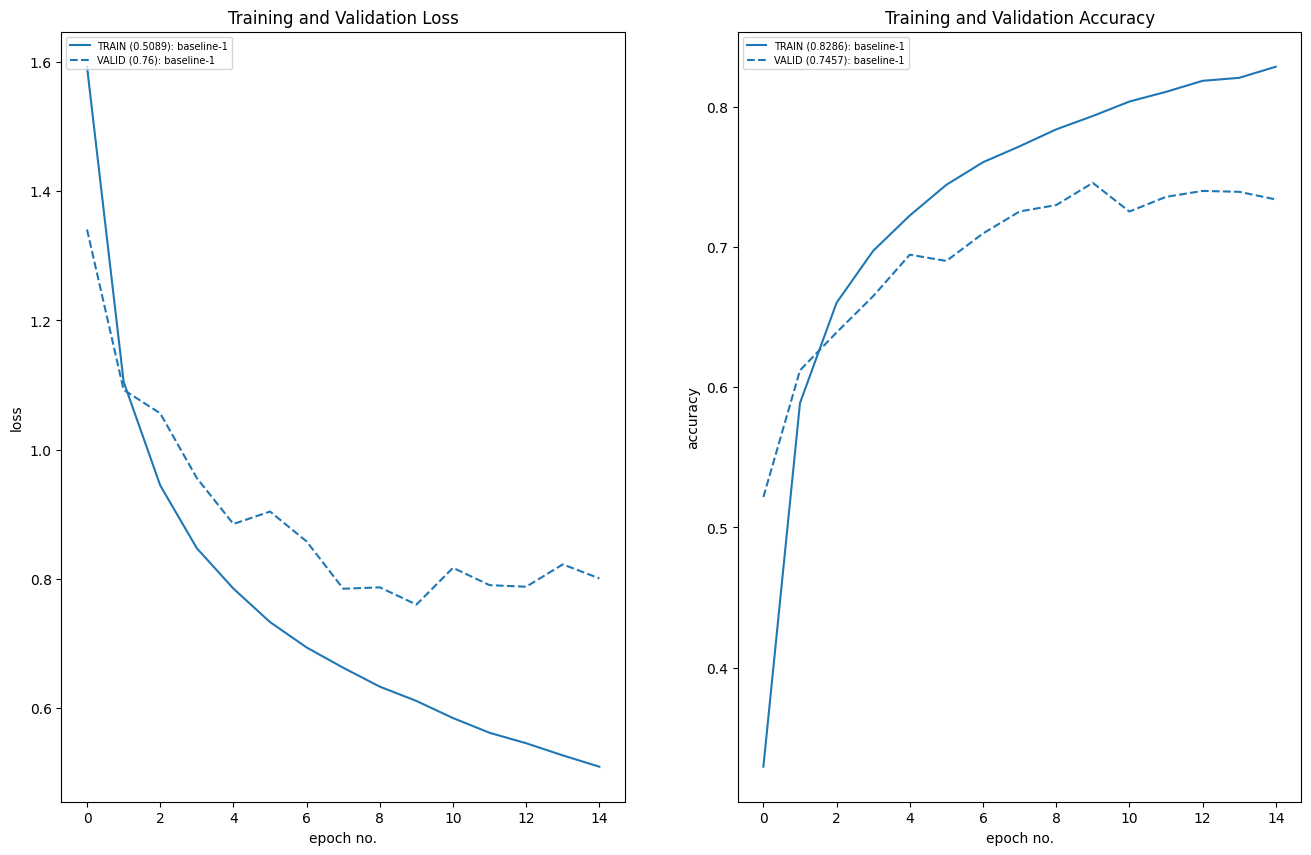

In [36]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-1'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

### Adding dropouts

In [90]:
class Cifar_Baseline_DP(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels, multiplier=1):
    super(Cifar_Baseline_DP, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), # 30,3
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units,  kernel_size=3, stride=1, padding=0), #28,5
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #28,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #14,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #12,10
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #10,14
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #8,18
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.transition2= nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #8,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #4,20
    )

    self.conv3 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #2,28
        nn.BatchNorm2d(multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,36
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,44
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.gap = self.gap = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=1, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.transition2(x)
      x = self.conv3(x)
      x = self.gap(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [91]:
# New Model Instance
baseline_model_2 = Cifar_Baseline_DP(in_channels=3, hidden_units=16, out_channels=10 , multiplier=2).to(device)
summary(baseline_model_2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
       BatchNorm2d-6           [-1, 32, 28, 28]              64
              ReLU-7           [-1, 32, 28, 28]               0
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]             528
      BatchNorm2d-10           [-1, 16, 28, 28]              32
             ReLU-11           [-1, 16, 28, 28]               0
        MaxPool2d-12           [-1, 16, 14, 14]               0
           Conv2d-13           [-1, 32, 12, 12]           4,640
      BatchNorm2d-14           [-1, 32,

In [92]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

In [93]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_2, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], baseline_model_2, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 1.7377091737659387 Avg Train Metric: 0.27238754392661096: 100%|██████████| 391/391 [00:26<00:00, 14.55it/s]


Function Took 26.8921 seconds


Avg Test Loss: 1.385072536106351 Avg Test Metric: 0.5012363765058638: 100%|██████████| 79/79 [00:04<00:00, 17.15it/s]


Function Took 4.6152 seconds
Validation loss decreased (inf --> 1.385073).  Saving model ...
Epoch 1


Avg Train Loss: 1.2557950275938223 Avg Train Metric: 0.5281485897653243: 100%|██████████| 391/391 [00:21<00:00, 18.34it/s]


Function Took 21.3341 seconds


Avg Test Loss: 1.245120804521102 Avg Test Metric: 0.5684878049017508: 100%|██████████| 79/79 [00:03<00:00, 19.96it/s]


Function Took 3.9711 seconds
Validation loss decreased (1.385073 --> 1.245121).  Saving model ...
Epoch 2


Avg Train Loss: 1.0870218610824527 Avg Train Metric: 0.608730318296291: 100%|██████████| 391/391 [00:21<00:00, 17.79it/s]


Function Took 21.9956 seconds


Avg Test Loss: 1.068269583243358 Avg Test Metric: 0.6295836922488635: 100%|██████████| 79/79 [00:03<00:00, 22.31it/s]


Function Took 3.5528 seconds
Validation loss decreased (1.245121 --> 1.068270).  Saving model ...
Epoch 3


Avg Train Loss: 1.0016378072826453 Avg Train Metric: 0.6478365682579977: 100%|██████████| 391/391 [00:22<00:00, 17.53it/s]


Function Took 22.3214 seconds


Avg Test Loss: 1.0489784003813056 Avg Test Metric: 0.6437708803370029: 100%|██████████| 79/79 [00:03<00:00, 23.05it/s]


Function Took 3.4394 seconds
Validation loss decreased (1.068270 --> 1.048978).  Saving model ...
Epoch 4


Avg Train Loss: 0.943004619892296 Avg Train Metric: 0.6707047320082974: 100%|██████████| 391/391 [00:22<00:00, 17.50it/s]


Function Took 22.3589 seconds


Avg Test Loss: 0.9326488805722587 Avg Test Metric: 0.6779677437830575: 100%|██████████| 79/79 [00:03<00:00, 23.53it/s]


Function Took 3.3629 seconds
Validation loss decreased (1.048978 --> 0.932649).  Saving model ...
Epoch 5


Avg Train Loss: 0.8983855268839375 Avg Train Metric: 0.6852014984011345: 100%|██████████| 391/391 [00:22<00:00, 17.66it/s]


Function Took 22.1521 seconds


Avg Test Loss: 0.9265158802648134 Avg Test Metric: 0.6826048259493671: 100%|██████████| 79/79 [00:03<00:00, 23.84it/s]


Function Took 3.3202 seconds
Validation loss decreased (0.932649 --> 0.926516).  Saving model ...
Epoch 6


Avg Train Loss: 0.8631385371203313 Avg Train Metric: 0.6985822489194553: 100%|██████████| 391/391 [00:22<00:00, 17.46it/s]


Function Took 22.4081 seconds


Avg Test Loss: 0.9075826323485072 Avg Test Metric: 0.681026058860972: 100%|██████████| 79/79 [00:03<00:00, 23.67it/s]


Function Took 3.3487 seconds
Validation loss decreased (0.926516 --> 0.907583).  Saving model ...
Epoch 7


Avg Train Loss: 0.8402218079323049 Avg Train Metric: 0.7020918100386324: 100%|██████████| 391/391 [00:22<00:00, 17.55it/s]


Function Took 22.2861 seconds


Avg Test Loss: 0.8128929096686689 Avg Test Metric: 0.7207572588437721: 100%|██████████| 79/79 [00:03<00:00, 23.56it/s]


Function Took 3.3667 seconds
Validation loss decreased (0.907583 --> 0.812893).  Saving model ...
Epoch 8


Avg Train Loss: 0.8144022195845309 Avg Train Metric: 0.7159350018976899: 100%|██████████| 391/391 [00:22<00:00, 17.38it/s]


Function Took 22.5151 seconds


Avg Test Loss: 0.8574375517760651 Avg Test Metric: 0.709665034390703: 100%|██████████| 79/79 [00:03<00:00, 23.17it/s]


Function Took 3.4205 seconds
EarlyStopping counter: 1 out of 5
Epoch 9


Avg Train Loss: 0.7966209814676544 Avg Train Metric: 0.7229775396149482: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s]


Function Took 21.7628 seconds


Avg Test Loss: 0.8207057646558255 Avg Test Metric: 0.7174527569662167: 100%|██████████| 79/79 [00:03<00:00, 20.05it/s]


Function Took 3.9528 seconds
EarlyStopping counter: 2 out of 5
Epoch 10


Avg Train Loss: 0.780790346205387 Avg Train Metric: 0.7330440840757716: 100%|██████████| 391/391 [00:22<00:00, 17.15it/s]


Function Took 22.8072 seconds


Avg Test Loss: 0.8032605391514452 Avg Test Metric: 0.7271593379068978: 100%|██████████| 79/79 [00:05<00:00, 15.10it/s]


Function Took 5.2443 seconds
Validation loss decreased (0.812893 --> 0.803261).  Saving model ...
Epoch 11


Avg Train Loss: 0.7573723837237833 Avg Train Metric: 0.7373529184809731: 100%|██████████| 391/391 [00:28<00:00, 13.77it/s]


Function Took 28.4051 seconds


Avg Test Loss: 0.7972990319698672 Avg Test Metric: 0.7301724802089643: 100%|██████████| 79/79 [00:04<00:00, 17.84it/s]


Function Took 4.4407 seconds
Validation loss decreased (0.803261 --> 0.797299).  Saving model ...
Epoch 12


Avg Train Loss: 0.7450594332669397 Avg Train Metric: 0.7455253218445936: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]


Function Took 27.8769 seconds


Avg Test Loss: 0.8134296302553974 Avg Test Metric: 0.7184984382194809: 100%|██████████| 79/79 [00:05<00:00, 15.56it/s]


Function Took 5.0963 seconds
EarlyStopping counter: 1 out of 5
Epoch 13


Avg Train Loss: 0.7350958765620161 Avg Train Metric: 0.7454212760681387: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


Function Took 22.8603 seconds


Avg Test Loss: 0.7289521037777767 Avg Test Metric: 0.7432666104051131: 100%|██████████| 79/79 [00:03<00:00, 21.22it/s]


Function Took 3.7338 seconds
Validation loss decreased (0.797299 --> 0.728952).  Saving model ...
Epoch 14


Avg Train Loss: 0.7256506942117306 Avg Train Metric: 0.7507455981600925: 100%|██████████| 391/391 [00:21<00:00, 17.87it/s]


Function Took 21.8935 seconds


Avg Test Loss: 0.760517375378669 Avg Test Metric: 0.7454710934735551: 100%|██████████| 79/79 [00:04<00:00, 19.37it/s]


Function Took 4.0901 seconds
EarlyStopping counter: 1 out of 5
Epoch 15


Avg Train Loss: 0.7133151919335661 Avg Train Metric: 0.7546984128025181: 100%|██████████| 391/391 [00:21<00:00, 18.10it/s]


Function Took 21.6120 seconds


Avg Test Loss: 0.7519273931467081 Avg Test Metric: 0.7418278968786891: 100%|██████████| 79/79 [00:04<00:00, 18.33it/s]


Function Took 4.3241 seconds
EarlyStopping counter: 2 out of 5
Epoch 16


Avg Train Loss: 0.7042970402009042 Avg Train Metric: 0.7630715931163115: 100%|██████████| 391/391 [00:21<00:00, 18.09it/s]


Function Took 21.6226 seconds


Avg Test Loss: 0.7522358577462691 Avg Test Metric: 0.7462212058562266: 100%|██████████| 79/79 [00:04<00:00, 17.30it/s]


Function Took 4.5754 seconds
EarlyStopping counter: 3 out of 5
Epoch 17


Avg Train Loss: 0.6942714766773117 Avg Train Metric: 0.7637767338996653: 100%|██████████| 391/391 [00:24<00:00, 16.03it/s]


Function Took 24.3998 seconds


Avg Test Loss: 0.7342434978183312 Avg Test Metric: 0.7521213723134391: 100%|██████████| 79/79 [00:04<00:00, 16.01it/s]


Function Took 4.9466 seconds
EarlyStopping counter: 4 out of 5
Epoch 18


Avg Train Loss: 0.6857378045311364 Avg Train Metric: 0.7665175899215366: 100%|██████████| 391/391 [00:24<00:00, 16.14it/s]


Function Took 24.2406 seconds


Avg Test Loss: 0.7000972813443292 Avg Test Metric: 0.7632362714296654: 100%|██████████| 79/79 [00:03<00:00, 23.42it/s]


Function Took 3.3912 seconds
Validation loss decreased (0.728952 --> 0.700097).  Saving model ...
Epoch 19


Avg Train Loss: 0.6798620992304419 Avg Train Metric: 0.764670375820316: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s]


Function Took 22.5889 seconds


Avg Test Loss: 0.6763313831407812 Avg Test Metric: 0.7644868613798407: 100%|██████████| 79/79 [00:03<00:00, 22.07it/s]


Function Took 3.5861 seconds
Validation loss decreased (0.700097 --> 0.676331).  Saving model ...


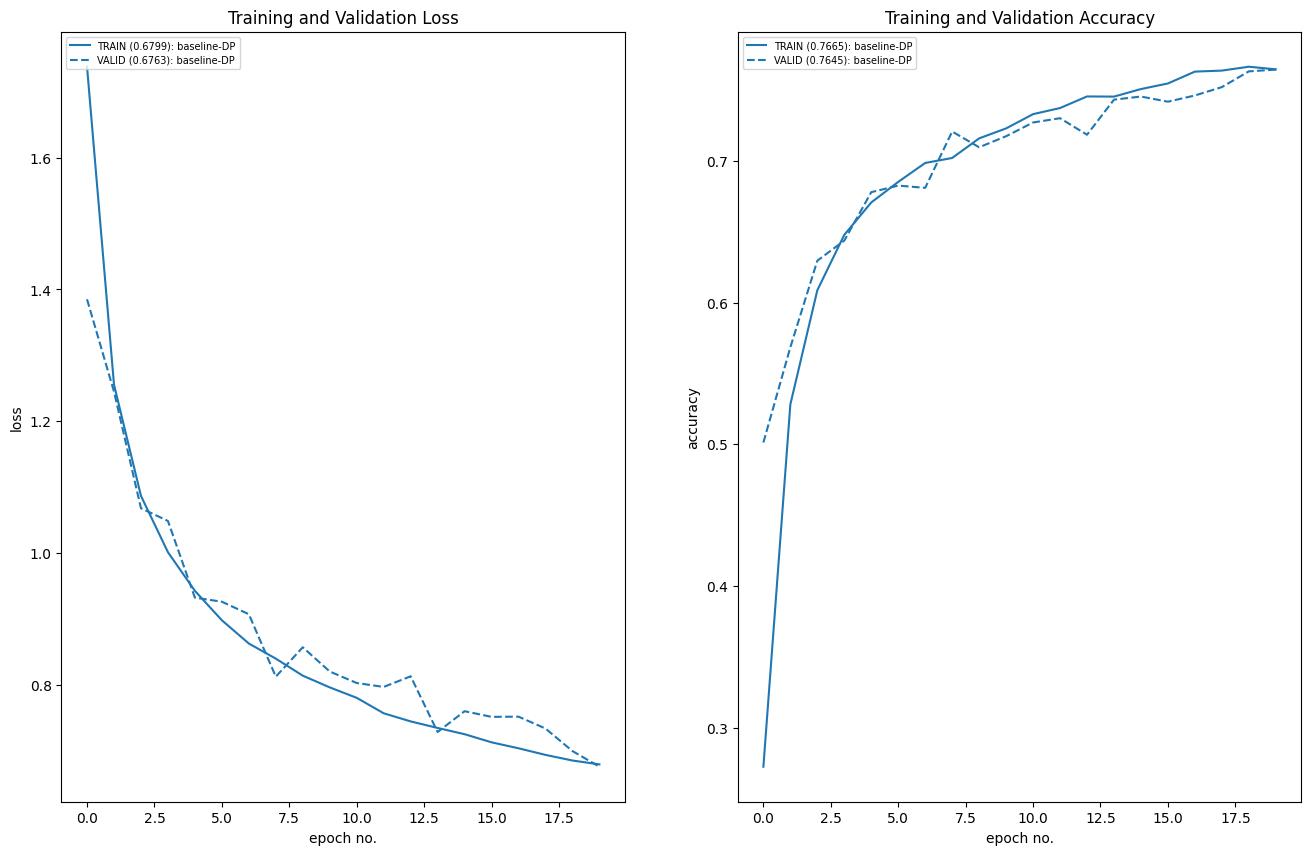

In [94]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-DP'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

## Eval Framework and Metrics

In [103]:
def eval_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                ):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  predictions = []
  actuals = []

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      actuals.append(label)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      # metric calc
      preds = torch.argmax(preds,dim=1)

      predictions.append(preds)

  return torch.cat(actuals, dim=0).cpu().numpy(), torch.cat(predictions, dim=0).cpu().numpy()

In [104]:
eval_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
actuals , predictions = eval_module(baseline_model_2, device, eval_loader)

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


In [105]:
min(actuals),max(actuals)

(0, 9)

## Metrics

In [106]:
cmatrix = confusion_matrix(actuals, predictions)
print(classification_report(actuals, predictions, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.71      0.86      0.78      1000
  automobile       0.91      0.86      0.89      1000
        bird       0.68      0.66      0.67      1000
         cat       0.56      0.62      0.59      1000
        deer       0.72      0.77      0.75      1000
         dog       0.69      0.62      0.65      1000
        frog       0.87      0.80      0.84      1000
       horse       0.83      0.78      0.80      1000
        ship       0.87      0.84      0.86      1000
       truck       0.87      0.85      0.86      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



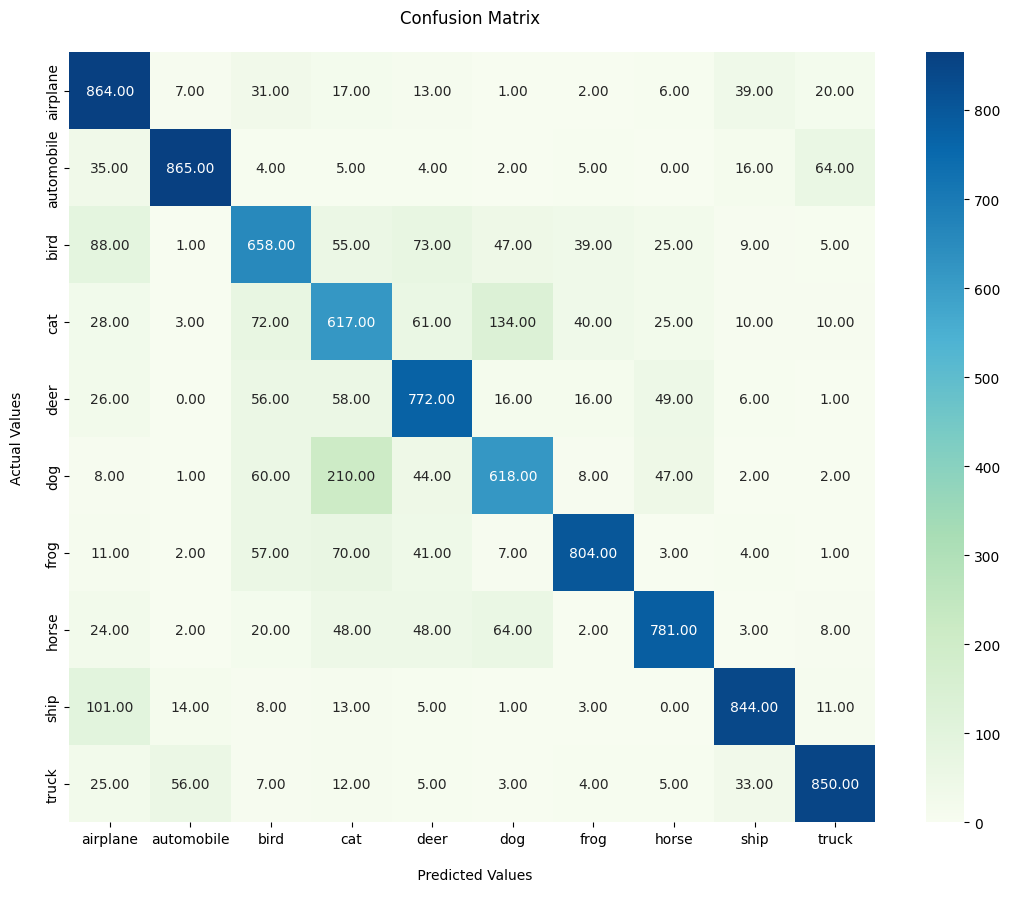

In [107]:
plt.figure(figsize=(13,10))
fx=sns.heatmap(cmatrix, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(classes)
fx.yaxis.set_ticklabels(classes)
plt.show()

In [108]:
mismatches = np.where(predictions != actuals)

In [109]:
# idx = mismatches[0][0]
# print(f'Actual: {classes[actuals[idx]]}')
# print(f'Predicted: {classes[predictions[idx]]}')

Label: airplane and Prediction: cat


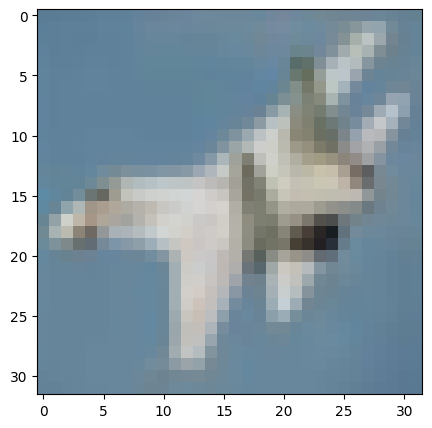

Label: dog and Prediction: deer


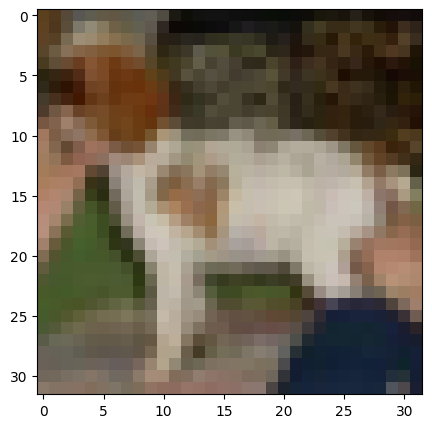

Label: dog and Prediction: deer


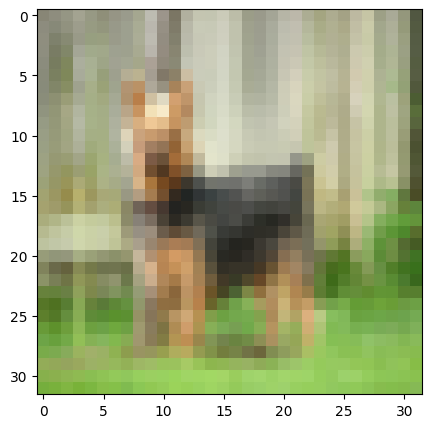

Label: dog and Prediction: cat


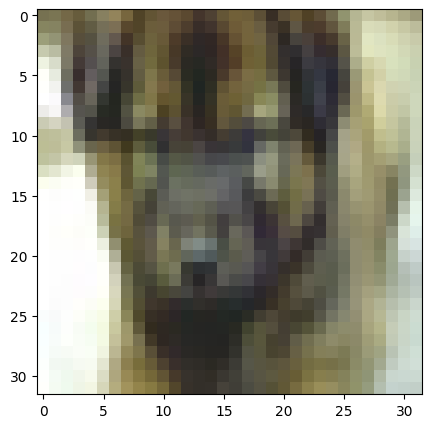

Label: bird and Prediction: cat


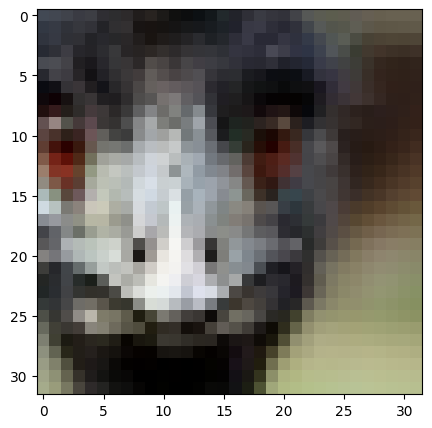

Label: deer and Prediction: horse


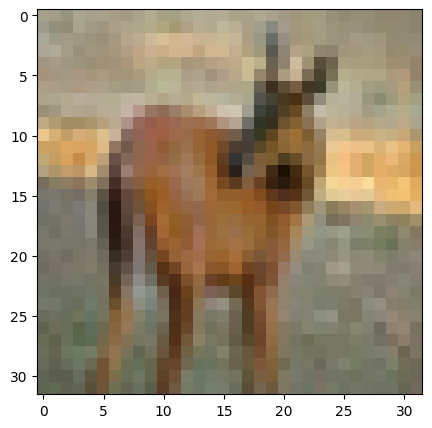

Label: automobile and Prediction: truck


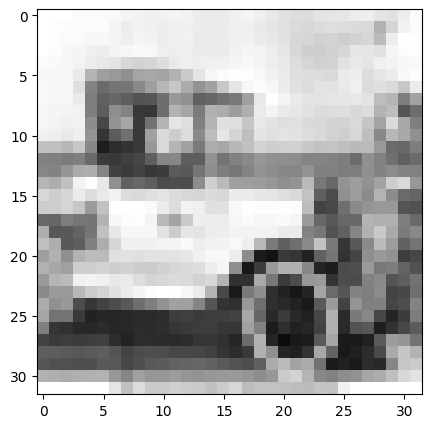

Label: deer and Prediction: airplane


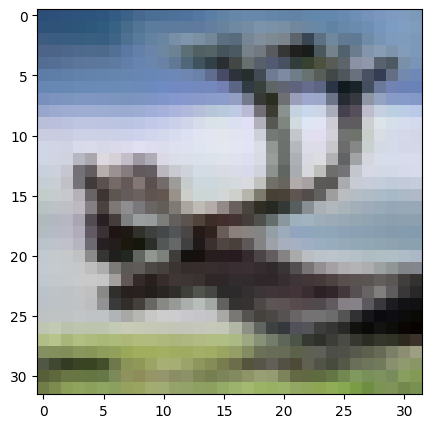

Label: dog and Prediction: horse


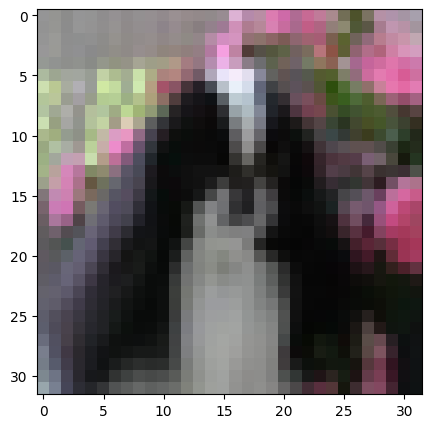

Label: airplane and Prediction: horse


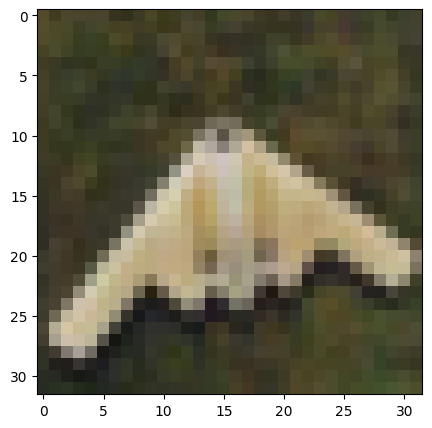

In [110]:
for idx in mismatches[0][:10]:
  plt.figure(figsize=(5,5))
  img, label = test[idx]
  imshow(img)
  print(f'Label: {classes[label]} and Prediction: {classes[predictions[idx]]}')
  plt.show()

Sumamry:

- The model used is a Cifar_Baseline, which is a convolutional neural network with three convolution blocks, each followed by a transition block.
- The model achieved a training accuracy of 76% and a validation accuracy of 76%.
- The model's training loss was 0.67 and its validation loss was 0.67.
- The model's confusion matrix showed that it was most accurate at classifying Autombile and least accurate at classifying Cats.
- Early stopping was triggered after 14 epochs due to lack of improvement in validation loss.
- Addition of Dropouts makes a significant difference in terms of overfitting.